# Modeling Google Mobility Data due to COVID-19 in 2020

This tutorial is based on the version in R by [Adriana Picoral](https://github.com/picoral), which you can find [here](http://htmlpreview.github.io/?https://github.com/picoral/pit-un-2022/blob/master/R%20tutorials/google-mobility.html).

For this case study we will be using Google’s data on [COVID-19 Community Mobility](https://www.google.com/covid19/mobility/index.html?hl=en). You can both download and access more details about this data at the previous link. In this tutorial, we will focus on data from the United States in 2020. The website also includes data from 2019 and 2021.

First, let's import the packages we need. We'll also silence warnings, as the warnings for these plots are extensive given the amount of data and color palettes we're using. In order to use this tutorial you will need to make sure all of these packages are installed - if you have the Anaconda version of Python, you will specifically need to install [`seaborn`](https://seaborn.pydata.org/installing.html) and [`plotly`](https://plotly.com/python/getting-started/).

In [1]:
import pandas as pd, plotly.express as px, statsmodels.api as sm, matplotlib.pyplot as plt, seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Dealing with data

First, we can import the csv for the data we're interested in from the regional Google Mobility data zip file. The one used here is the 2020 US Region report. Once we've read in the data, we can take a look at it to get a better feel for the variables and data formats we have at our disposal.

In [2]:
us_mobil_2020 = pd.read_csv('data/2020_US_Region_Mobility_Report.csv')

In [3]:
us_mobil_2020.head()

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,US,United States,NaN,NaN,NaN,NaN,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,2020-02-15,6.0,2.0,15.0,3.0,2.0,-1.0
1,US,United States,NaN,NaN,NaN,NaN,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,2020-02-16,7.0,1.0,16.0,2.0,0.0,-1.0
2,US,United States,NaN,NaN,NaN,NaN,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,2020-02-17,6.0,0.0,28.0,-9.0,-24.0,5.0
3,US,United States,NaN,NaN,NaN,NaN,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,2020-02-18,0.0,-1.0,6.0,1.0,0.0,1.0
4,US,United States,NaN,NaN,NaN,NaN,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,2020-02-19,2.0,0.0,8.0,1.0,1.0,0.0


After taking a look at the dataframe above, we notice there's a lot of region information at different levels of granularity. For this analysis, we'll use `sub_region_1` because we're going to complete our analysis at the state regional level. Additionally, we'll want to extract the place mobility information that allows us to assess change from baseline - for example, `retail_and_recreation_percent_change_from_baseline` (what a (descriptive) mouthful).

In [4]:
region_placeID = us_mobil_2020.loc[:,["sub_region_1","place_id"]].copy()
changes = us_mobil_2020.loc[:,"retail_and_recreation_percent_change_from_baseline":"residential_percent_change_from_baseline"].copy()
mobil_sub = pd.concat((region_placeID, changes), axis = 1)
mobil_sub.head()

,sub_region_1,place_id,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,6.0,2.0,15.0,3.0,2.0,-1.0
1,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,7.0,1.0,16.0,2.0,0.0,-1.0
2,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,6.0,0.0,28.0,-9.0,-24.0,5.0
3,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,0.0,-1.0,6.0,1.0,0.0,1.0
4,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,2.0,0.0,8.0,1.0,1.0,0.0


Once we've extracted the variables we're interested in from the raw data, we can start to preprocess the data. First, we'll remove the `_percent_change_from_baseline` suffix from any variables that contain it, and then we'll use [`pandas.melt`](https://pandas.pydata.org/pandas-docs/version/1.0.0/reference/api/pandas.melt.html#pandas.melt) to "melt" our dataframe from wide to long format (`place` will become a new column, along with `percent_change_from_baseline`).

In [5]:
mobil_sub.columns = [col_name.replace("_percent_change_from_baseline", "") for col_name in mobil_sub.columns]
mobil_sub

,sub_region_1,place_id,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
0,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,6.0,2.0,15.0,3.0,2.0,-1.0
1,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,7.0,1.0,16.0,2.0,0.0,-1.0
2,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,6.0,0.0,28.0,-9.0,-24.0,5.0
3,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,0.0,-1.0,6.0,1.0,0.0,1.0
4,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,2.0,0.0,8.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...
812060,Wyoming,ChIJd4Rqhed3YocR7ubT5-HgoJg,NaN,NaN,NaN,NaN,-56.0,NaN
812061,Wyoming,ChIJd4Rqhed3YocR7ubT5-HgoJg,NaN,NaN,NaN,NaN,-40.0,NaN
812062,Wyoming,ChIJd4Rqhed3YocR7ubT5-HgoJg,NaN,NaN,NaN,NaN,-43.0,NaN
812063,Wyoming,ChIJd4Rqhed3YocR7ubT5-HgoJg,NaN,NaN,NaN,NaN,-40.0,NaN


In [6]:
mobil_2020_tidy = pd.melt(mobil_sub, 
                                id_vars = ["sub_region_1", "place_id"],
                                var_name = "place",
                                value_name = "percent_change_from_baseline")
mobil_2020_tidy

,sub_region_1,place_id,place,percent_change_from_baseline
0,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,retail_and_recreation,6.0
1,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,retail_and_recreation,7.0
2,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,retail_and_recreation,6.0
3,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,retail_and_recreation,0.0
4,NaN,ChIJCzYy5IS16lQRQrfeQ5K5Oxw,retail_and_recreation,2.0
...,...,...,...,...
4872385,Wyoming,ChIJd4Rqhed3YocR7ubT5-HgoJg,residential,NaN
4872386,Wyoming,ChIJd4Rqhed3YocR7ubT5-HgoJg,residential,NaN
4872387,Wyoming,ChIJd4Rqhed3YocR7ubT5-HgoJg,residential,NaN
4872388,Wyoming,ChIJd4Rqhed3YocR7ubT5-HgoJg,residential,NaN


### Model and Visualize the effect of State and Place on Mobility

We can use [`statsmodels.OLS.from_formula`](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.from_formula.html) to predict percent mobility change (`percent_change_from_baseline`) as a function of (`~`) state (`sub_region_1`) and `place`. Notice how many rows we have in our data - almost 5 million! It might take 30 seconds or so (don't be alarmed).

In [7]:
formula = "percent_change_from_baseline ~ sub_region_1 + place"
model = sm.OLS.from_formula(formula = formula,
                            data = mobil_2020_tidy)
results = model.fit()

After that, we can get the model predictions and the summary dataframe before we begin to aggregate the results by state and place.

In [8]:
predict_results = results.get_prediction()
result_frame = predict_results.summary_frame()
print(result_frame)

              mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
321      -8.964392  0.093604      -9.147852      -8.780933    -53.930294   
322      -8.964392  0.093604      -9.147852      -8.780933    -53.930294   
323      -8.964392  0.093604      -9.147852      -8.780933    -53.930294   
324      -8.964392  0.093604      -9.147852      -8.780933    -53.930294   
325      -8.964392  0.093604      -9.147852      -8.780933    -53.930294   
...            ...       ...            ...            ...           ...   
4871954  14.217973  0.175799      13.873412      14.562533    -30.748875   
4871957  14.217973  0.175799      13.873412      14.562533    -30.748875   
4871958  14.217973  0.175799      13.873412      14.562533    -30.748875   
4871959  14.217973  0.175799      13.873412      14.562533    -30.748875   
4871960  14.217973  0.175799      13.873412      14.562533    -30.748875   

         obs_ci_upper  
321         36.001509  
322         36.001509  
323         36.

As we can see above, the summarized predictions no longer contain state or place information, so in order to make our lives easier (and know what each of the result observations refers to), we can add those variables back into the dataframe.

In [9]:
result_frame.insert(0, "state", mobil_2020_tidy["sub_region_1"].copy())
result_frame.insert(1, "place", mobil_2020_tidy["place"].copy())

In [10]:
result_frame

,state,place,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
321,Alabama,retail_and_recreation,-8.964392,0.093604,-9.147852,-8.780933,-53.930294,36.001509
322,Alabama,retail_and_recreation,-8.964392,0.093604,-9.147852,-8.780933,-53.930294,36.001509
323,Alabama,retail_and_recreation,-8.964392,0.093604,-9.147852,-8.780933,-53.930294,36.001509
324,Alabama,retail_and_recreation,-8.964392,0.093604,-9.147852,-8.780933,-53.930294,36.001509
325,Alabama,retail_and_recreation,-8.964392,0.093604,-9.147852,-8.780933,-53.930294,36.001509
...,...,...,...,...,...,...,...,...
4871954,Wyoming,residential,14.217973,0.175799,13.873412,14.562533,-30.748875,59.184820
4871957,Wyoming,residential,14.217973,0.175799,13.873412,14.562533,-30.748875,59.184820
4871958,Wyoming,residential,14.217973,0.175799,13.873412,14.562533,-30.748875,59.184820
4871959,Wyoming,residential,14.217973,0.175799,13.873412,14.562533,-30.748875,59.184820


There are a few things we can notice about the rows of this dataframe  - there appear to be a significant number of repeats in the data for each place within each state. Therefore, we can group our dataframe by `state`, then `place` and aggregate using the mean. Finally, we can also update the place names so they no longer have underscores in place of spaces, to prepare for visualizing our results.

In [11]:
result_frame.dropna(subset = "state", inplace = True)
result_frame = result_frame.groupby(['state', 'place']).mean()
result_frame.reset_index(level = ["state", "place"], inplace = True)
result_frame['place'] = [place.replace("_", " ") for place in result_frame['place']]
result_frame

,state,place,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,Alabama,grocery and pharmacy,2.325717,0.093900,2.141676,2.509757,-42.640187,47.291621
1,Alabama,parks,31.213234,0.103137,31.011089,31.415378,-13.752748,76.179216
2,Alabama,residential,8.695328,0.094897,8.509332,8.881324,-36.270584,53.661240
3,Alabama,retail and recreation,-8.964392,0.093604,-9.147852,-8.780933,-53.930294,36.001509
4,Alabama,transit stations,-10.726891,0.097719,-10.918417,-10.535366,-55.692827,34.239044
...,...,...,...,...,...,...,...,...
301,Wyoming,parks,36.735878,0.180231,36.382632,37.089125,-8.231037,81.702793
302,Wyoming,residential,14.217973,0.175799,13.873412,14.562533,-30.748875,59.184820
303,Wyoming,retail and recreation,-3.441748,0.174893,-3.784532,-3.098963,-48.408582,41.525086
304,Wyoming,transit stations,-5.204247,0.176662,-5.550498,-4.857996,-50.171107,39.762613


We can run an [ANOVA](https://www.statisticshowto.com/probability-and-statistics/hypothesis-testing/anova/) test, in case reporting on significance of findings is necessary. ANOVA is a hypothesis test that is used to determine if the relationships between our features/factors (the independent variables - state and place) and the dependent variable (percent mobility change) are significant. See the above link for more information. We will use [`statsmodels.stats.anova_lm`](https://www.statsmodels.org/dev/generated/statsmodels.stats.anova.anova_lm.html).

In [12]:
sm.stats.anova_lm(results, typ = "II")

,sum_sq,df,F,PR(>F)
sub_region_1,5.387358e+07,50.0,2047.118540,0.0
place,6.169537e+08,5.0,234433.531397,0.0
Residual,1.449817e+09,2754548.0,NaN,NaN


### Visualize the effect of Place on Mobility

After fitting our model and hypothesis testing, we can visualize our results.

First, we'll visualize the effect of `place` on `mean` percent mobility change. To do this, we'll create a [`seaborn.pointplot`](https://seaborn.pydata.org/generated/seaborn.pointplot.html). The points in the point plot will be based on the aggregated `mean` across each distinct `place` and the error bars are the standard deviation of those estimates.

[Text(0.5, 1.0, 'Mobility Change in the United States\nacross place types, pre-pandemic baseline at 0'),
 Text(0.5, 0, 'average mobility change from pre-pandemic baseline')]

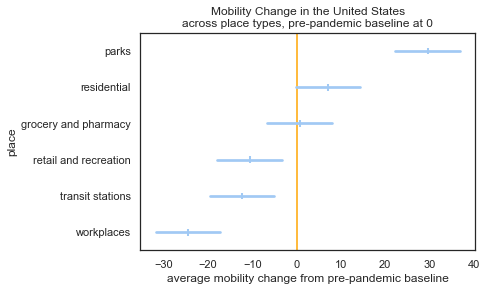

In [13]:
sns.set_theme(style="white")
sns.set_palette('pastel', n_colors = len(result_frame))

result_frame.sort_values(by = "mean", ascending = False, inplace = True)

# create plot
# set figure size and set padding around subplots to "tight" 
# (to make sure labs are included)
# plt.figure(figsize=[6, 5])
plt.tight_layout()

# add vertical line at 0 (baseline)
plt.axvline(x = 0, color = "orange")

# add place errorbars
ax = sns.pointplot(y = "place", 
                x= "mean", 
                orient = "h",
                ci = 'sd',
                data = result_frame,
                join = False,
                markers = "|")

# set axis labels
ax.set(title = "Mobility Change in the United States\nacross place types, pre-pandemic baseline at 0",
        xlabel = "average mobility change from pre-pandemic baseline")

In the plot above, we can see that the average mobility change by place was greatest in parks - which saw increased mobility during 2020 compared to the pre-pandemic baseline (0). By contrast, workplaces had the greatest *decrease* in mobility, dropping by somewhere around 25%.

### Visualize the effect of State on Mobility

We can also use `plotly` to visualize the effect of state on average mobility change. First we have to re-group the data so that it's grouped by state only, to prepare for the visualization. Plotly will give us the tools we need to create an interactive [chloropleth map](https://plotly.github.io/plotly.py-docs/generated/plotly.express.choropleth.html), which is pretty cool! Plotly is backed by JavaScript, which lends its dynamic functionality (and it's available in multiple languages, too!).

In [14]:
ave_mobil_by_state = result_frame.groupby(['state']).mean()
ave_mobil_by_state.reset_index(level = ["state"], inplace = True)

# read state codes to create chloropleth
state_codes_df = pd.read_csv('https://raw.githubusercontent.com/jackparmer/iso-3166-state-codes/master/codes.csv')
# state_codes_df.to_csv("data/state_codes.csv")
state_codes_df['state'] = [state_code.strip() for state_code in state_codes_df['state']]

# create map
fig = px.choropleth(ave_mobil_by_state,
                    locations = [state_codes_df.loc[state_codes_df['state'].eq(state).idxmax(), "code"]
                                for state in ave_mobil_by_state.state], 
                    locationmode="USA-states", 
                    color='mean',
                    color_continuous_scale="Earth",
                    # color_continuous_midpoint = 0,
                    range_color = [-30, 10],
                    scope="usa",
                    labels={'locations':'state','mean':'avg. change (%)'},
                    title = "Mobility Change in the United States, across states",
                    width = 630,
                    height = 450)
fig.show()

![chloropleth map](chloropleth_example.png)

The chloropleth map is really beautiful, with nice colors, but in static (meaning, non-interactive/unchanging) versions, chloropleth maps aren't necessarily the best way to understand the distinctions between states - we aren't actually visualizing their exact differences, since we can't see the values unless we interact with this plot. Therefore, we can make another pointplot to visualize the differences in percent mobility change by state:

[Text(0.5, 1.0, 'Mobility Change in the United States\nacross states, pre-pandemic baseline at 0'),
 Text(0.5, 0, 'average mobility change from pre-pandemic baseline')]

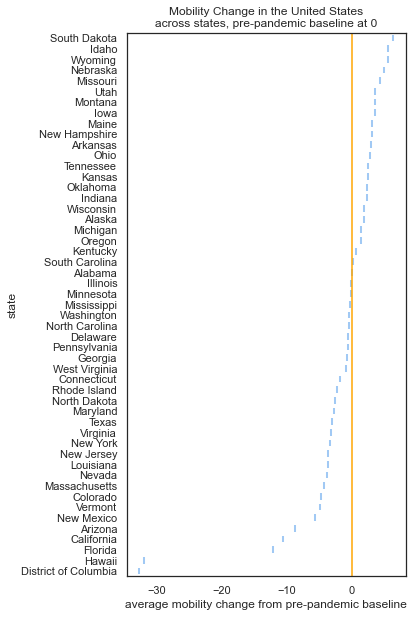

In [15]:
ave_mobil_by_state.sort_values(by = "mean", ascending = False, inplace = True)

sns.set_theme(style="white")
sns.set_palette('pastel')

# create plot
# set figure size and set padding around subplots to "tight" 
# (to make sure labs are included)
plt.figure(figsize=[5, 10])
plt.tight_layout()

# add vertical line at 0 (baseline)
plt.axvline(x = 0, color = "orange")

# add place errorbars
ax = sns.pointplot(y = "state", 
                x= "mean", 
                orient = "h",
                data = ave_mobil_by_state,
                join = False,
                markers = "|")

# set axis labels
ax.set(title = "Mobility Change in the United States\nacross states, pre-pandemic baseline at 0",
        xlabel = "average mobility change from pre-pandemic baseline")

Which of these two plots that display mobility change by state would you use? Why? Could there be benefit to using each of them in different scenarios?